# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Like'
PRFX='Like0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL like
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 3.23 s, sys: 500 ms, total: 3.73 s
Wall time: 3.73 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(500000, 24)


retwt          0.113632
reply          0.027396
like           0.438598
retwt_cmmnt    0.007824
dtype: float64

CPU times: user 4.11 s, sys: 352 ms, total: 4.46 s
Wall time: 4.46 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.438598
500000 219299 500000 219299


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
0,101\t56898\t137\t14248\t10567\t77966\t11166\t1...,NaN,A964AF200DAFFEBCB632CE2196DFBE6F,NaN,NaN,NaN,Retweet,022EC308651FACB02794A8147AEE1B78,1581227402,E43C242721C2336F88D163ADFDB2A364,27901,306,False,1351736247,06E9B34C49824F5C612B01F3DF66C4B8,48,977,False,1493475569,False,True,False,False,False
1,101\t29922\t10230\t112\t11368\t112\t12469\t169...,NaN,CA95806CCD16ADD6164D8B632345A5B6,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581415813,520F4141FB74447AA2D5100C12656DF2,190829,2227,True,1246308293,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,False,False,True,False
2,101\t16358\t10107\t117\t146\t100\t181\t32342\t...,NaN,EAB281F4E0B985324DB134D922D7753C,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581524517,EC1254C86CED1D8F2B556786329FD939,225223,1365,True,1238211373,06E9B485CA5F2757CB554B0244FE2FA4,2024,1227,False,1234745553,False,True,False,True,False
3,101\t49004\t24951\t11517\t21793\t49004\t46900\...,E35EBE28C67E02E3EAABD4D383303A10\tBF43374FADDC...,55F436653590B79DC49DCA2FC5E6BA6E,Photo,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581098413,09567D1DEB473ABA2CD04D06F1F6D22D,3110429,39,True,1243169868,06E9B6ABEB6C57CA5A394DADF375D940,557,466,False,1509320658,False,False,False,True,False
4,101\t320\t108660\t18492\t105861\t26349\t10174\...,NaN,2F374BA8A03CFA7B51594FBBD45E4BA6,Photo,E07397470C5AD4AC2420A832A49E045B,476213C6321CD12B64C1FB76A6CE02CA,TopLevel,4DC22C3F31C5C43721E6B5815A595ED6,1581158393,DF856F242E9519638FD447D0CCFA06DF,4245504,54,True,1248789982,06E9B7217C92B280231E835F1B686176,8,74,False,1346060212,False,False,False,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-12 02:29:45 start
2020-04-12 02:29:53 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-12 02:30:05 freq of tags
2020-04-12 02:30:09 done
CPU times: user 20.8 s, sys: 3 s, total: 23.8 s
Wall time: 23.6 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-12 02:30:09 start
2020-04-12 02:30:16 freq of columns using CountEncoder
2020-04-12 02:30:28 freq of tags
2020-04-12 02:30:32 done
CPU times: user 20.3 s, sys: 2.97 s, total: 23.3 s
Wall time: 23.2 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 21 s, sys: 3.98 s, total: 24.9 s
Wall time: 24.9 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
 'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
 'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
36


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.560444	vl's binary_logloss: 0.570928
[200]	tr's binary_logloss: 0.549211	vl's binary_logloss: 0.566757
[300]	tr's binary_logloss: 0.542415	vl's binary_logloss: 0.565907
[400]	tr's binary_logloss: 0.536594	vl's binary_logloss: 0.565206
[500]	tr's binary_logloss: 0.531524	vl's binary_logloss: 0.564807
[600]	tr's binary_logloss: 0.52677	vl's binary_logloss: 0.564348
[700]	tr's binary_logloss: 0.521845	vl's binary_logloss: 0.564105
[800]	tr's binary_logloss: 0.517007	vl's binary_logloss: 0.564072
[900]	tr's binary_logloss: 0.512839	vl's binary_logloss: 0.563768
[1000]	tr's binary_logloss: 0.508823	vl's binary_logloss: 0.563544
[1100]	tr's binary_logloss: 0.504887	vl's binary_logloss: 0.563644
Early stopping, best iteration is:
[1028]	tr's binary_logloss: 0.507708	vl's binary_logloss: 0.563472


tune_feature_fraction, val_score: 0.563472:  14%|#4        | 1/7 [00:22<02:12, 22.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.559229	vl's binary_logloss: 0.570441
[200]	tr's binary_logloss: 0.547729	vl's binary_logloss: 0.567181
[300]	tr's binary_logloss: 0.540117	vl's binary_logloss: 0.566184
[400]	tr's binary_logloss: 0.534313	vl's binary_logloss: 0.56529
[500]	tr's binary_logloss: 0.528313	vl's binary_logloss: 0.565101
[600]	tr's binary_logloss: 0.522726	vl's binary_logloss: 0.564597
[700]	tr's binary_logloss: 0.518134	vl's binary_logloss: 0.564647
Early stopping, best iteration is:
[657]	tr's binary_logloss: 0.520115	vl's binary_logloss: 0.56455


tune_feature_fraction, val_score: 0.563472:  29%|##8       | 2/7 [00:36<01:39, 19.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.557963	vl's binary_logloss: 0.570796
[200]	tr's binary_logloss: 0.546126	vl's binary_logloss: 0.567555
[300]	tr's binary_logloss: 0.538192	vl's binary_logloss: 0.56676
[400]	tr's binary_logloss: 0.531726	vl's binary_logloss: 0.566236
[500]	tr's binary_logloss: 0.526052	vl's binary_logloss: 0.566237
Early stopping, best iteration is:
[428]	tr's binary_logloss: 0.530079	vl's binary_logloss: 0.566129


tune_feature_fraction, val_score: 0.563472:  43%|####2     | 3/7 [00:48<01:09, 17.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.557227	vl's binary_logloss: 0.571165
[200]	tr's binary_logloss: 0.544795	vl's binary_logloss: 0.568143
[300]	tr's binary_logloss: 0.536831	vl's binary_logloss: 0.567594
[400]	tr's binary_logloss: 0.529921	vl's binary_logloss: 0.567135
[500]	tr's binary_logloss: 0.523754	vl's binary_logloss: 0.566959
[600]	tr's binary_logloss: 0.518084	vl's binary_logloss: 0.566926
Early stopping, best iteration is:
[510]	tr's binary_logloss: 0.523153	vl's binary_logloss: 0.56688


tune_feature_fraction, val_score: 0.563472:  57%|#####7    | 4/7 [01:01<00:48, 16.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.556122	vl's binary_logloss: 0.571537
[200]	tr's binary_logloss: 0.543185	vl's binary_logloss: 0.569123
[300]	tr's binary_logloss: 0.53514	vl's binary_logloss: 0.568299
[400]	tr's binary_logloss: 0.527826	vl's binary_logloss: 0.567989
[500]	tr's binary_logloss: 0.521035	vl's binary_logloss: 0.567946
Early stopping, best iteration is:
[424]	tr's binary_logloss: 0.526098	vl's binary_logloss: 0.567864


tune_feature_fraction, val_score: 0.563472:  71%|#######1  | 5/7 [01:13<00:29, 14.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.555155	vl's binary_logloss: 0.571769
[200]	tr's binary_logloss: 0.541963	vl's binary_logloss: 0.569137
[300]	tr's binary_logloss: 0.533432	vl's binary_logloss: 0.568877
[400]	tr's binary_logloss: 0.526225	vl's binary_logloss: 0.568754
[500]	tr's binary_logloss: 0.519536	vl's binary_logloss: 0.568703
Early stopping, best iteration is:
[485]	tr's binary_logloss: 0.520749	vl's binary_logloss: 0.568579


tune_feature_fraction, val_score: 0.563472:  86%|########5 | 6/7 [01:26<00:14, 14.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.55462	vl's binary_logloss: 0.572035
[200]	tr's binary_logloss: 0.540699	vl's binary_logloss: 0.569932
[300]	tr's binary_logloss: 0.532146	vl's binary_logloss: 0.569698
[400]	tr's binary_logloss: 0.524126	vl's binary_logloss: 0.569765
Early stopping, best iteration is:
[348]	tr's binary_logloss: 0.528234	vl's binary_logloss: 0.56955


tune_num_leaves, val_score: 0.563472:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.562237	vl's binary_logloss: 0.57187
[200]	tr's binary_logloss: 0.551484	vl's binary_logloss: 0.567566
[300]	tr's binary_logloss: 0.544585	vl's binary_logloss: 0.566225
[400]	tr's binary_logloss: 0.539199	vl's binary_logloss: 0.565529
[500]	tr's binary_logloss: 0.534238	vl's binary_logloss: 0.565222
[600]	tr's binary_logloss: 0.529963	vl's binary_logloss: 0.564856
[700]	tr's binary_logloss: 0.525423	vl's binary_logloss: 0.56458
[800]	tr's binary_logloss: 0.521125	vl's binary_logloss: 0.564243
[900]	tr's binary_logloss: 0.517117	vl's binary_logloss: 0.564133
[1000]	tr's binary_logloss: 0.513369	vl's binary_logloss: 0.563838
[1100]	tr's binary_logloss: 0.509604	vl's binary_logloss: 0.563843
Early stopping, best iteration is:
[1022]	tr's binary_logloss: 0.512553	vl's binary_logloss: 0.56374


tune_num_leaves, val_score: 0.563472:   5%|5         | 1/20 [00:19<06:10, 19.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.542012	vl's binary_logloss: 0.566045
[200]	tr's binary_logloss: 0.524541	vl's binary_logloss: 0.563938
[300]	tr's binary_logloss: 0.511237	vl's binary_logloss: 0.563491
[400]	tr's binary_logloss: 0.499758	vl's binary_logloss: 0.563527
Early stopping, best iteration is:
[324]	tr's binary_logloss: 0.508464	vl's binary_logloss: 0.563398


tune_num_leaves, val_score: 0.563398:  10%|#         | 2/20 [00:31<05:12, 17.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.53778	vl's binary_logloss: 0.565571
[200]	tr's binary_logloss: 0.518455	vl's binary_logloss: 0.563449
[300]	tr's binary_logloss: 0.503623	vl's binary_logloss: 0.563371
[400]	tr's binary_logloss: 0.490691	vl's binary_logloss: 0.563307
Early stopping, best iteration is:
[366]	tr's binary_logloss: 0.495252	vl's binary_logloss: 0.563115


tune_num_leaves, val_score: 0.563115:  15%|#5        | 3/20 [00:46<04:40, 16.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.540547	vl's binary_logloss: 0.565784
[200]	tr's binary_logloss: 0.522357	vl's binary_logloss: 0.56385
[300]	tr's binary_logloss: 0.50884	vl's binary_logloss: 0.563766
[400]	tr's binary_logloss: 0.49701	vl's binary_logloss: 0.56342
[500]	tr's binary_logloss: 0.485847	vl's binary_logloss: 0.563457
[600]	tr's binary_logloss: 0.475733	vl's binary_logloss: 0.56343
Early stopping, best iteration is:
[551]	tr's binary_logloss: 0.480563	vl's binary_logloss: 0.563308


tune_num_leaves, val_score: 0.563115:  20%|##        | 4/20 [01:04<04:32, 17.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.527471	vl's binary_logloss: 0.564372
[200]	tr's binary_logloss: 0.502003	vl's binary_logloss: 0.562991
Early stopping, best iteration is:
[185]	tr's binary_logloss: 0.505086	vl's binary_logloss: 0.562946


tune_num_leaves, val_score: 0.562946:  25%|##5       | 5/20 [01:17<03:56, 15.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515005	vl's binary_logloss: 0.563193
[200]	tr's binary_logloss: 0.481599	vl's binary_logloss: 0.5626
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.483722	vl's binary_logloss: 0.562399


tune_num_leaves, val_score: 0.562399:  30%|###       | 6/20 [01:33<03:39, 15.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.542728	vl's binary_logloss: 0.566333
[200]	tr's binary_logloss: 0.525629	vl's binary_logloss: 0.564112
[300]	tr's binary_logloss: 0.512469	vl's binary_logloss: 0.563238
[400]	tr's binary_logloss: 0.501691	vl's binary_logloss: 0.562722
[500]	tr's binary_logloss: 0.49171	vl's binary_logloss: 0.562735
[600]	tr's binary_logloss: 0.482162	vl's binary_logloss: 0.562826
Early stopping, best iteration is:
[507]	tr's binary_logloss: 0.49103	vl's binary_logloss: 0.562644


tune_num_leaves, val_score: 0.562399:  35%|###5      | 7/20 [01:49<03:27, 15.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.521951	vl's binary_logloss: 0.563977
[200]	tr's binary_logloss: 0.493232	vl's binary_logloss: 0.563669
Early stopping, best iteration is:
[154]	tr's binary_logloss: 0.504552	vl's binary_logloss: 0.563364


tune_num_leaves, val_score: 0.562399:  40%|####      | 8/20 [02:01<02:58, 14.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.517762	vl's binary_logloss: 0.56353
[200]	tr's binary_logloss: 0.485725	vl's binary_logloss: 0.562365
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.490816	vl's binary_logloss: 0.56223


tune_num_leaves, val_score: 0.562230:  45%|####5     | 9/20 [02:16<02:42, 14.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.54302	vl's binary_logloss: 0.566522
[200]	tr's binary_logloss: 0.526236	vl's binary_logloss: 0.563777
[300]	tr's binary_logloss: 0.513963	vl's binary_logloss: 0.563405
[400]	tr's binary_logloss: 0.50261	vl's binary_logloss: 0.563446
Early stopping, best iteration is:
[347]	tr's binary_logloss: 0.508688	vl's binary_logloss: 0.563319


tune_num_leaves, val_score: 0.562230:  50%|#####     | 10/20 [02:29<02:22, 14.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515997	vl's binary_logloss: 0.56355
[200]	tr's binary_logloss: 0.483634	vl's binary_logloss: 0.562392
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.488035	vl's binary_logloss: 0.562308


tune_num_leaves, val_score: 0.562230:  55%|#####5    | 11/20 [02:44<02:09, 14.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.514431	vl's binary_logloss: 0.563145
[200]	tr's binary_logloss: 0.481037	vl's binary_logloss: 0.562282
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.486215	vl's binary_logloss: 0.562133


tune_num_leaves, val_score: 0.562133:  60%|######    | 12/20 [02:59<01:56, 14.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.520948	vl's binary_logloss: 0.563872
[200]	tr's binary_logloss: 0.490974	vl's binary_logloss: 0.563112
Early stopping, best iteration is:
[182]	tr's binary_logloss: 0.495477	vl's binary_logloss: 0.562845


tune_num_leaves, val_score: 0.562133:  65%|######5   | 13/20 [03:12<01:40, 14.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513922	vl's binary_logloss: 0.563445
[200]	tr's binary_logloss: 0.479493	vl's binary_logloss: 0.561947
Early stopping, best iteration is:
[197]	tr's binary_logloss: 0.480328	vl's binary_logloss: 0.561917


tune_num_leaves, val_score: 0.561917:  70%|#######   | 14/20 [03:29<01:29, 14.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.528179	vl's binary_logloss: 0.564551
[200]	tr's binary_logloss: 0.502359	vl's binary_logloss: 0.563002
[300]	tr's binary_logloss: 0.482879	vl's binary_logloss: 0.563383
Early stopping, best iteration is:
[219]	tr's binary_logloss: 0.498288	vl's binary_logloss: 0.562941


tune_num_leaves, val_score: 0.561917:  75%|#######5  | 15/20 [03:42<01:11, 14.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513922	vl's binary_logloss: 0.563445
[200]	tr's binary_logloss: 0.479493	vl's binary_logloss: 0.561947
Early stopping, best iteration is:
[197]	tr's binary_logloss: 0.480328	vl's binary_logloss: 0.561917


tune_num_leaves, val_score: 0.561917:  80%|########  | 16/20 [03:57<00:59, 14.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.573687	vl's binary_logloss: 0.577522
[200]	tr's binary_logloss: 0.56472	vl's binary_logloss: 0.571998
[300]	tr's binary_logloss: 0.55992	vl's binary_logloss: 0.570097
[400]	tr's binary_logloss: 0.556235	vl's binary_logloss: 0.568814
[500]	tr's binary_logloss: 0.553148	vl's binary_logloss: 0.568029
[600]	tr's binary_logloss: 0.550358	vl's binary_logloss: 0.567377
[700]	tr's binary_logloss: 0.547759	vl's binary_logloss: 0.567032
[800]	tr's binary_logloss: 0.545287	vl's binary_logloss: 0.566458
[900]	tr's binary_logloss: 0.542981	vl's binary_logloss: 0.565973
[1000]	tr's binary_logloss: 0.540797	vl's binary_logloss: 0.565712
[1100]	tr's binary_logloss: 0.538609	vl's binary_logloss: 0.565395
[1200]	tr's binary_logloss: 0.536483	vl's binary_logloss: 0.565267
[1300]	tr's binary_logloss: 0.534628	vl's binary_logloss: 0.565103
[1400]	tr's binary_logloss: 0.532707	vl's binary_logloss: 0.564908
[1500]	tr's

tune_num_leaves, val_score: 0.561917:  85%|########5 | 17/20 [04:29<00:59, 19.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.52667	vl's binary_logloss: 0.564117
[200]	tr's binary_logloss: 0.500372	vl's binary_logloss: 0.562686
[300]	tr's binary_logloss: 0.480481	vl's binary_logloss: 0.562943
Early stopping, best iteration is:
[222]	tr's binary_logloss: 0.495494	vl's binary_logloss: 0.562429


tune_num_leaves, val_score: 0.561917:  90%|######### | 18/20 [04:42<00:35, 17.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513922	vl's binary_logloss: 0.563445
[200]	tr's binary_logloss: 0.479493	vl's binary_logloss: 0.561947
Early stopping, best iteration is:
[197]	tr's binary_logloss: 0.480328	vl's binary_logloss: 0.561917


tune_num_leaves, val_score: 0.561917:  95%|#########5| 19/20 [04:58<00:17, 17.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.521227	vl's binary_logloss: 0.56374
[200]	tr's binary_logloss: 0.491694	vl's binary_logloss: 0.563046
[300]	tr's binary_logloss: 0.469455	vl's binary_logloss: 0.562845
Early stopping, best iteration is:
[283]	tr's binary_logloss: 0.473167	vl's binary_logloss: 0.562594


tune_num_leaves, val_score: 0.561917: 100%|##########| 20/20 [05:17<00:00, 15.85s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.519683	vl's binary_logloss: 0.565327
[200]	tr's binary_logloss: 0.486039	vl's binary_logloss: 0.564641
Early stopping, best iteration is:
[155]	tr's binary_logloss: 0.500226	vl's binary_logloss: 0.564464


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  10%|#         | 1/10 [00:14<02:08, 14.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.519087	vl's binary_logloss: 0.564631
[200]	tr's binary_logloss: 0.485573	vl's binary_logloss: 0.56414
Early stopping, best iteration is:
[160]	tr's binary_logloss: 0.498097	vl's binary_logloss: 0.563995


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  20%|##        | 2/10 [00:28<01:54, 14.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515298	vl's binary_logloss: 0.563996
[200]	tr's binary_logloss: 0.482063	vl's binary_logloss: 0.563471
[300]	tr's binary_logloss: 0.457148	vl's binary_logloss: 0.563588
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.470418	vl's binary_logloss: 0.563093


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  30%|###       | 3/10 [00:47<01:50, 15.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.51971	vl's binary_logloss: 0.565036
[200]	tr's binary_logloss: 0.486566	vl's binary_logloss: 0.56427
Early stopping, best iteration is:
[197]	tr's binary_logloss: 0.487431	vl's binary_logloss: 0.564187


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  40%|####      | 4/10 [01:04<01:35, 15.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.522587	vl's binary_logloss: 0.56549
[200]	tr's binary_logloss: 0.489491	vl's binary_logloss: 0.566
Early stopping, best iteration is:
[129]	tr's binary_logloss: 0.51191	vl's binary_logloss: 0.564987


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  50%|#####     | 5/10 [01:16<01:14, 14.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.521709	vl's binary_logloss: 0.566026
[200]	tr's binary_logloss: 0.488526	vl's binary_logloss: 0.56566
Early stopping, best iteration is:
[163]	tr's binary_logloss: 0.500043	vl's binary_logloss: 0.565045


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  60%|######    | 6/10 [01:30<00:58, 14.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.518898	vl's binary_logloss: 0.564874
[200]	tr's binary_logloss: 0.485662	vl's binary_logloss: 0.564523
Early stopping, best iteration is:
[151]	tr's binary_logloss: 0.500893	vl's binary_logloss: 0.564133


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  70%|#######   | 7/10 [01:44<00:43, 14.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.525257	vl's binary_logloss: 0.567479
[200]	tr's binary_logloss: 0.492623	vl's binary_logloss: 0.568425
Early stopping, best iteration is:
[112]	tr's binary_logloss: 0.520825	vl's binary_logloss: 0.567311


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  80%|########  | 8/10 [01:55<00:26, 13.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.514251	vl's binary_logloss: 0.56338
[200]	tr's binary_logloss: 0.481217	vl's binary_logloss: 0.562847
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.49252	vl's binary_logloss: 0.562833


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917:  90%|######### | 9/10 [02:10<00:13, 13.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515765	vl's binary_logloss: 0.563646
[200]	tr's binary_logloss: 0.482436	vl's binary_logloss: 0.562752
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.484398	vl's binary_logloss: 0.562684


tune_bagging_fraction_and_bagging_freq, val_score: 0.561917: 100%|##########| 10/10 [02:27<00:00, 14.73s/it]
tune_feature_fraction, val_score: 0.561917:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.512231	vl's binary_logloss: 0.563355
[200]	tr's binary_logloss: 0.478605	vl's binary_logloss: 0.56259
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.480599	vl's binary_logloss: 0.562503


tune_feature_fraction, val_score: 0.561917:  33%|###3      | 1/3 [00:15<00:30, 15.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.510441	vl's binary_logloss: 0.563317
[200]	tr's binary_logloss: 0.476193	vl's binary_logloss: 0.562583
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.478314	vl's binary_logloss: 0.562471


tune_feature_fraction, val_score: 0.561917:  67%|######6   | 2/3 [00:30<00:15, 15.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.50999	vl's binary_logloss: 0.563499
[200]	tr's binary_logloss: 0.475475	vl's binary_logloss: 0.563409
Early stopping, best iteration is:
[193]	tr's binary_logloss: 0.477551	vl's binary_logloss: 0.56328


tune_feature_fraction, val_score: 0.561917: 100%|##########| 3/3 [00:46<00:00, 15.44s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.561917:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.51502	vl's binary_logloss: 0.563376
[200]	tr's binary_logloss: 0.480822	vl's binary_logloss: 0.561741
[300]	tr's binary_logloss: 0.455327	vl's binary_logloss: 0.562456
Early stopping, best iteration is:
[225]	tr's binary_logloss: 0.474269	vl's binary_logloss: 0.56165


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:   5%|5         | 1/20 [00:17<05:26, 17.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.51351	vl's binary_logloss: 0.563488
[200]	tr's binary_logloss: 0.479619	vl's binary_logloss: 0.562667
[300]	tr's binary_logloss: 0.454372	vl's binary_logloss: 0.562881
Early stopping, best iteration is:
[265]	tr's binary_logloss: 0.46319	vl's binary_logloss: 0.562428


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  10%|#         | 2/20 [00:35<05:17, 17.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513549	vl's binary_logloss: 0.563424
[200]	tr's binary_logloss: 0.48019	vl's binary_logloss: 0.562215
[300]	tr's binary_logloss: 0.453753	vl's binary_logloss: 0.562574
Early stopping, best iteration is:
[238]	tr's binary_logloss: 0.469823	vl's binary_logloss: 0.562006


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  15%|#5        | 3/20 [00:53<05:01, 17.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513952	vl's binary_logloss: 0.563663
[200]	tr's binary_logloss: 0.480107	vl's binary_logloss: 0.562918
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.492068	vl's binary_logloss: 0.562635


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  20%|##        | 4/20 [01:08<04:27, 16.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513553	vl's binary_logloss: 0.563333
[200]	tr's binary_logloss: 0.479478	vl's binary_logloss: 0.562677
[300]	tr's binary_logloss: 0.453096	vl's binary_logloss: 0.563116
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.467399	vl's binary_logloss: 0.562606


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  25%|##5       | 5/20 [01:25<04:15, 17.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513734	vl's binary_logloss: 0.563403
[200]	tr's binary_logloss: 0.479425	vl's binary_logloss: 0.562708
[300]	tr's binary_logloss: 0.453429	vl's binary_logloss: 0.562971
Early stopping, best iteration is:
[259]	tr's binary_logloss: 0.463851	vl's binary_logloss: 0.562658


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  30%|###       | 6/20 [01:44<04:04, 17.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513705	vl's binary_logloss: 0.56367
[200]	tr's binary_logloss: 0.47943	vl's binary_logloss: 0.562558
[300]	tr's binary_logloss: 0.452515	vl's binary_logloss: 0.563078
Early stopping, best iteration is:
[223]	tr's binary_logloss: 0.472756	vl's binary_logloss: 0.562389


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  35%|###5      | 7/20 [02:01<03:46, 17.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513822	vl's binary_logloss: 0.563311
[200]	tr's binary_logloss: 0.479686	vl's binary_logloss: 0.562172
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.48161	vl's binary_logloss: 0.562018


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  40%|####      | 8/20 [02:17<03:23, 16.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515036	vl's binary_logloss: 0.563373
[200]	tr's binary_logloss: 0.482846	vl's binary_logloss: 0.562305
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.487714	vl's binary_logloss: 0.56214


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  45%|####5     | 9/20 [02:33<03:01, 16.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513778	vl's binary_logloss: 0.563307
[200]	tr's binary_logloss: 0.479912	vl's binary_logloss: 0.56273
[300]	tr's binary_logloss: 0.453165	vl's binary_logloss: 0.563087
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.467585	vl's binary_logloss: 0.562523


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  50%|#####     | 10/20 [02:51<02:50, 17.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.516694	vl's binary_logloss: 0.563841
[200]	tr's binary_logloss: 0.483763	vl's binary_logloss: 0.562666
[300]	tr's binary_logloss: 0.45963	vl's binary_logloss: 0.563138
Early stopping, best iteration is:
[213]	tr's binary_logloss: 0.480403	vl's binary_logloss: 0.562549


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  55%|#####5    | 11/20 [03:09<02:35, 17.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513929	vl's binary_logloss: 0.563247
[200]	tr's binary_logloss: 0.479759	vl's binary_logloss: 0.562033
[300]	tr's binary_logloss: 0.454353	vl's binary_logloss: 0.563012
Early stopping, best iteration is:
[220]	tr's binary_logloss: 0.474434	vl's binary_logloss: 0.561914


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  60%|######    | 12/20 [03:26<02:17, 17.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513906	vl's binary_logloss: 0.563478
[200]	tr's binary_logloss: 0.479683	vl's binary_logloss: 0.562725
Early stopping, best iteration is:
[190]	tr's binary_logloss: 0.482619	vl's binary_logloss: 0.562544


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  65%|######5   | 13/20 [03:41<01:57, 16.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.520923	vl's binary_logloss: 0.564087
[200]	tr's binary_logloss: 0.49086	vl's binary_logloss: 0.56288
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.492793	vl's binary_logloss: 0.562723


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  70%|#######   | 14/20 [04:00<01:43, 17.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513743	vl's binary_logloss: 0.563538
[200]	tr's binary_logloss: 0.480536	vl's binary_logloss: 0.562197
[300]	tr's binary_logloss: 0.454813	vl's binary_logloss: 0.562455
Early stopping, best iteration is:
[263]	tr's binary_logloss: 0.464134	vl's binary_logloss: 0.562038


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  75%|#######5  | 15/20 [04:19<01:28, 17.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.51416	vl's binary_logloss: 0.563392
[200]	tr's binary_logloss: 0.480371	vl's binary_logloss: 0.562843
[300]	tr's binary_logloss: 0.454056	vl's binary_logloss: 0.563272
Early stopping, best iteration is:
[228]	tr's binary_logloss: 0.473002	vl's binary_logloss: 0.562722


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  80%|########  | 16/20 [04:36<01:10, 17.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513713	vl's binary_logloss: 0.563227
[200]	tr's binary_logloss: 0.479336	vl's binary_logloss: 0.562309
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.48108	vl's binary_logloss: 0.562206


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  85%|########5 | 17/20 [04:53<00:51, 17.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513518	vl's binary_logloss: 0.563684
[200]	tr's binary_logloss: 0.479641	vl's binary_logloss: 0.562392
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.484272	vl's binary_logloss: 0.562356


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  90%|######### | 18/20 [05:07<00:33, 16.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.513695	vl's binary_logloss: 0.563333
[200]	tr's binary_logloss: 0.479708	vl's binary_logloss: 0.562295
Early stopping, best iteration is:
[183]	tr's binary_logloss: 0.484652	vl's binary_logloss: 0.562178


tune_lambda_l1_and_lambda_l2, val_score: 0.561650:  95%|#########5| 19/20 [05:23<00:16, 16.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.516173	vl's binary_logloss: 0.563922
[200]	tr's binary_logloss: 0.483051	vl's binary_logloss: 0.562618
[300]	tr's binary_logloss: 0.457556	vl's binary_logloss: 0.563029
Early stopping, best iteration is:
[245]	tr's binary_logloss: 0.471238	vl's binary_logloss: 0.562341


tune_lambda_l1_and_lambda_l2, val_score: 0.561650: 100%|##########| 20/20 [05:42<00:00, 17.12s/it]
tune_min_child_samples, val_score: 0.561650:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.514802	vl's binary_logloss: 0.56343
[200]	tr's binary_logloss: 0.481206	vl's binary_logloss: 0.562107
Early stopping, best iteration is:
[195]	tr's binary_logloss: 0.482514	vl's binary_logloss: 0.562029


tune_min_child_samples, val_score: 0.561650:  20%|##        | 1/5 [00:17<01:08, 17.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.514681	vl's binary_logloss: 0.563602
[200]	tr's binary_logloss: 0.480416	vl's binary_logloss: 0.562614
[300]	tr's binary_logloss: 0.454937	vl's binary_logloss: 0.562917
Early stopping, best iteration is:
[237]	tr's binary_logloss: 0.470817	vl's binary_logloss: 0.562511


tune_min_child_samples, val_score: 0.561650:  40%|####      | 2/5 [00:35<00:52, 17.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.514922	vl's binary_logloss: 0.563664
[200]	tr's binary_logloss: 0.481363	vl's binary_logloss: 0.562502
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.482975	vl's binary_logloss: 0.562405


tune_min_child_samples, val_score: 0.561650:  60%|######    | 3/5 [00:52<00:34, 17.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.515381	vl's binary_logloss: 0.563673
[200]	tr's binary_logloss: 0.482286	vl's binary_logloss: 0.563088
Early stopping, best iteration is:
[191]	tr's binary_logloss: 0.48462	vl's binary_logloss: 0.56296


tune_min_child_samples, val_score: 0.561650:  80%|########  | 4/5 [01:08<00:16, 16.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.516478	vl's binary_logloss: 0.564007
[200]	tr's binary_logloss: 0.482982	vl's binary_logloss: 0.563061
[300]	tr's binary_logloss: 0.458119	vl's binary_logloss: 0.56367
Early stopping, best iteration is:
[222]	tr's binary_logloss: 0.477094	vl's binary_logloss: 0.562981


tune_min_child_samples, val_score: 0.561650: 100%|##########| 5/5 [01:26<00:00, 17.26s/it]


CPU times: user 2h 17min 10s, sys: 6h 35min 44s, total: 8h 52min 55s
Wall time: 17min 16s


## best_params

In [20]:
best_params

{'lambda_l1': 1.0726343495391903,
 'lambda_l2': 1.080964559682188e-06,
 'num_leaves': 255,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

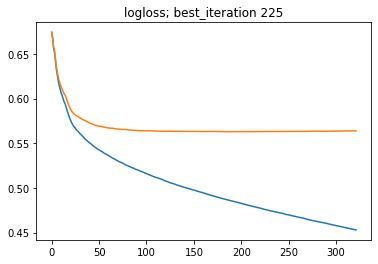

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

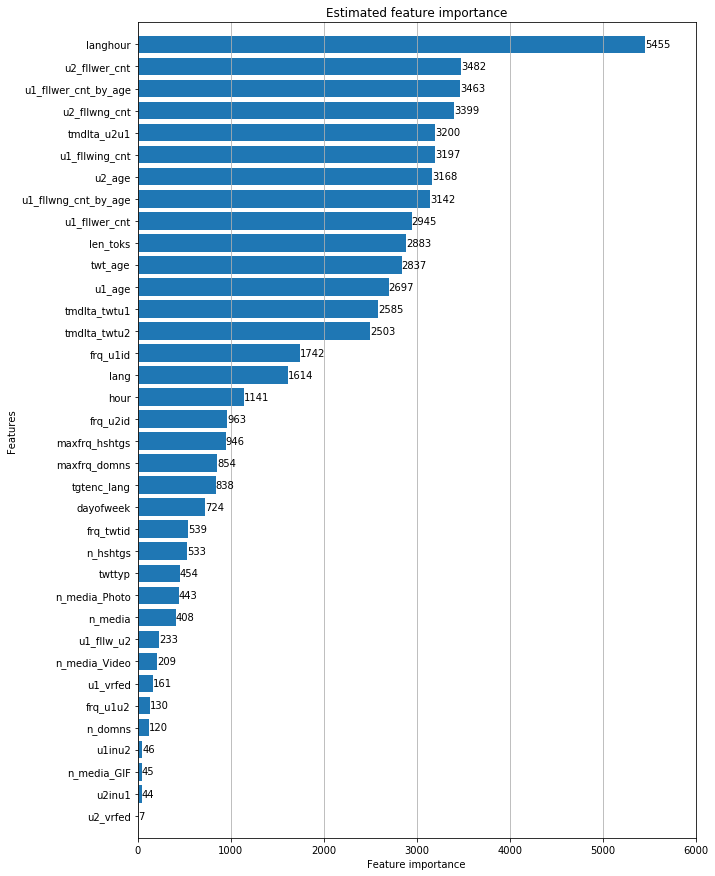

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,5455
5,u2_fllwer_cnt,3482
26,u1_fllwer_cnt_by_age,3463
6,u2_fllwng_cnt,3399
20,tmdlta_u2u1,3200
3,u1_fllwing_cnt,3197
25,u2_age,3168
27,u1_fllwng_cnt_by_age,3142
2,u1_fllwer_cnt,2945
11,len_toks,2883


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 5455),
 ('u2_fllwer_cnt', 3482),
 ('u1_fllwer_cnt_by_age', 3463),
 ('u2_fllwng_cnt', 3399),
 ('tmdlta_u2u1', 3200),
 ('u1_fllwing_cnt', 3197),
 ('u2_age', 3168),
 ('u1_fllwng_cnt_by_age', 3142),
 ('u1_fllwer_cnt', 2945),
 ('len_toks', 2883),
 ('twt_age', 2837),
 ('u1_age', 2697),
 ('tmdlta_twtu1', 2585),
 ('tmdlta_twtu2', 2503),
 ('frq_u1id', 1742),
 ('lang', 1614),
 ('hour', 1141),
 ('frq_u2id', 963),
 ('maxfrq_hshtgs', 946),
 ('maxfrq_domns', 854),
 ('tgtenc_lang', 838),
 ('dayofweek', 724),
 ('frq_twtid', 539),
 ('n_hshtgs', 533),
 ('twttyp', 454),
 ('n_media_Photo', 443),
 ('n_media', 408),
 ('u1_fllw_u2', 233),
 ('n_media_Video', 209),
 ('u1_vrfed', 161),
 ('frq_u1u2', 130),
 ('n_domns', 120),
 ('u1inu2', 46),
 ('n_media_GIF', 45),
 ('u2inu1', 44),
 ('u2_vrfed', 7)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u2_fllwer_cnt',
 'u1_fllwer_cnt_by_age',
 'u2_fllwng_cnt',
 'tmdlta_u2u1',
 'u1_fllwing_cnt',
 'u2_age',
 'u1_fllwng_cnt_by_age',
 'u1_fllwer_cnt',
 'len_toks',
 'twt_age',
 'u1_age',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'frq_u1id',
 'lang',
 'hour',
 'frq_u2id',
 'maxfrq_hshtgs',
 'maxfrq_domns',
 'tgtenc_lang',
 'dayofweek',
 'frq_twtid',
 'n_hshtgs',
 'twttyp',
 'n_media_Photo',
 'n_media',
 'u1_fllw_u2',
 'n_media_Video',
 'u1_vrfed',
 'frq_u1u2',
 'n_domns',
 'u1inu2',
 'n_media_GIF',
 'u2inu1',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 22s, sys: 17.5 s, total: 1min 39s
Wall time: 6.97 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 3.22 s, sys: 389 ms, total: 3.61 s
Wall time: 3.13 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.8397
auc_vl:  0.7298
auc_val: 0.7242

rce_tr:  30.8313
rce_vl:  18.0209
rce_val: 17.3361


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.7242-17.3361


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 44 ms, sys: 247 ms, total: 291 ms
Wall time: 11 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-12 02:48:29 start
2020-04-12 02:48:29 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-12 02:48:29 freq of tags
2020-04-12 02:48:29 done
CPU times: user 179 ms, sys: 200 ms, total: 379 ms
Wall time: 131 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 22.4 ms, sys: 66.5 ms, total: 88.9 ms
Wall time: 22.9 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)